In [ ]:
## Mount Google Drive Data
try:
    from google.colab import drive
    drive.mount("/content/drive")
except:
    print("Mounting Failed.")

In [ ]:
## Unzip files
import tarfile
tarfile_pth = '/content/drive/MyDrive/Colab Notebooks/Capstone/Task02_Heart.tar'
output_pth = '/content/drive/MyDrive/Colab Notebooks/Capstone/Data'
with tarfile.open(tarfile_pth, 'r') as tar:
    tar.extractall(path=output_pth)

In [ ]:
## Prepare Mamba environment
!pip install packaging
!pip install causal-conv1d
!pip install mamba-ssm
!pip install timm

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import sys
import argparse
import matplotlib.pyplot as plt

sys.path.append('./utils')
from utils.trainer import Trainer
from utils.dataset import get_data, ImageDataset
from utils.evaluation import evaluation
from utils.visualization import visualize_label
from utils.visualization import visualize_prediction

sys.path.append('./models')
from models import UNet, TransUnet #, MambaUnet

In [37]:
parser = argparse.ArgumentParser()
# Define path
parser.add_argument("--data_path", type=str, default="./Data/Task02_Heart")
parser.add_argument("--model_path", type=str, default="./checkpoints")
# Whether to continue training
parser.add_argument("--ct", type=bool, default=False)
# Define model
parser.add_argument("--model_name", type=str, default="unet")
parser.add_argument("--num_classes", type=int, default=2)
parser.add_argument("--n_skip", type=int, default=3)
parser.add_argument("--num_epochs", type=int, default=100)
# Define learning rate
parser.add_argument("--learning_rate", type=int, default=0.001)
# Define batch size
parser.add_argument("--train_batch", type=int, default=16)
parser.add_argument("--val_batch", type=int, default=16)
parser.add_argument("--test_batch", type=int, default=1)
args = parser.parse_args([])

In [3]:
# Use only labeled data
all_image, all_label = get_data(args.data_path, args.num_classes)
# Training 80%
# Validation 10%
# Testing 10%
train_data, temp_data, train_label, temp_label = train_test_split(all_image, all_label, test_size=0.2, random_state=0)
val_data, test_data, val_label, test_label = train_test_split(temp_data, temp_label, test_size=0.5, random_state=0)
del all_image
del all_label

In [4]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(1816, 224, 224)
(227, 224, 224)
(228, 224, 224)


In [5]:
print(train_label.shape)

(1816, 224, 224)


In [6]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(10)
])

In [7]:
train_dataset = ImageDataset(train_data, train_label, transform=transform)
val_dataset = ImageDataset(val_data, val_label)
test_dataset = ImageDataset(test_data, test_label)

train_dataloader = DataLoader(train_dataset, batch_size=args.train_batch, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=args.val_batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=args.test_batch, shuffle=False)

In [8]:
if args.model_name in ["unet", "transunet", "mambaunet"]:
    if args.model_name == "unet":
        model = UNet.UNet(args.num_classes)
    elif args.model_name == "transunet":
        model = TransUnet.TransUnet(args.num_classes, args.n_skip)
    else:
        model = MambaUnet.MambaUnet(args.num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.num_epochs, eta_min=0.00001)
    trainer = Trainer(args)
    trainer.train(model, optimizer, scheduler, train_dataloader, val_dataloader)
else:
    print("Wrong model type!")

Start Training transunet...
No checkpoint found to load.

EPOCH 1 of 100

training loss: 0.17536742789180657,
validation loss: 0.1130621075630188

EPOCH 2 of 100

training loss: 0.09843488089870989,
validation loss: 0.09054800967375437

EPOCH 3 of 100

training loss: 0.07733590041466973,
validation loss: 0.058122989783684416

EPOCH 4 of 100

training loss: 0.06933373533058584,
validation loss: 0.06267866666118303

EPOCH 5 of 100

training loss: 0.06162392939522601,
validation loss: 0.0626838631927967

EPOCH 6 of 100

training loss: 0.0529767030425239,
validation loss: 0.0463927316168944

EPOCH 7 of 100

training loss: 0.04896205987193083,
validation loss: 0.037634067982435224

EPOCH 8 of 100

training loss: 0.040803079705750735,
validation loss: 0.034843769793709116

EPOCH 9 of 100

training loss: 0.027895304742024132,
validation loss: 0.022337384273608527

EPOCH 10 of 100

training loss: 0.024448416252996315,
validation loss: 0.019038653497894607

EPOCH 11 of 100

training loss: 0.025

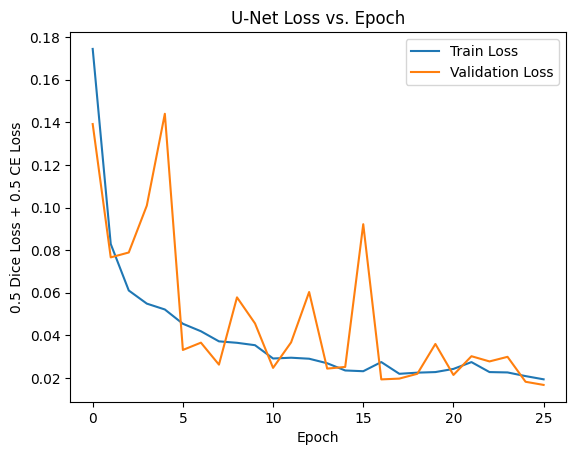

In [11]:
if args.model_name in ["unet", "transunet", "mambaunet"]:
    if args.model_name == "unet":
        model = UNet.UNet(args.num_classes)
        df_unet = evaluation(args, model, test_dataloader)
    elif args.model_name == "transunet":
        model = TransUnet.TransUnet(args.num_classes, args.n_skip)
        df_trans = evaluation(args, model, test_dataloader)
    else:
        model = MambaUnet.MambaUnet(args.num_classes)
        df_mamba = evaluation(args, model, test_dataloader)
    
else:
    print("Wrong model type!")

In [12]:
excel_path = os.path.join(args.model_path, "network_comparison.xlsx")
with pd.ExcelWriter(excel_path) as writer:
    df_unet.to_excel(writer, sheet_name="U-Net", index=False)
    df_trans.to_excel(writer, sheet_name="TransUNet", index=False)
    # df_mamba.to_excel(writer, sheet_name="MambaUNet", index=False)

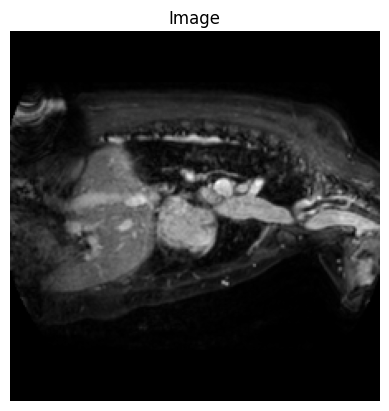

In [46]:
idx = 37
sample = test_dataset[idx]
sample_image = sample["data"].squeeze()
sample_label = sample["label"]
# Plot original
plt.imshow(sample_image, cmap="gray")
plt.title("Image")
plt.axis("off")
plt.show()

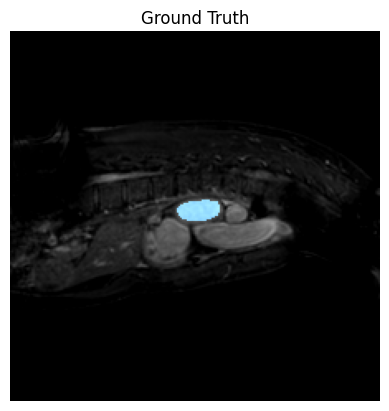

In [35]:
# Plot label
plt.imshow(visualize_label(sample_image, sample_label))
plt.title("Ground Truth")
plt.axis("off")
plt.show()

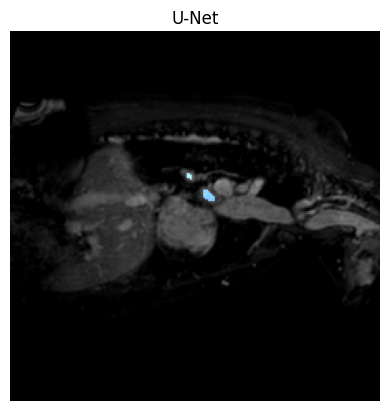

In [47]:
# Plot UNet Prediction
model = UNet.UNet(args.num_classes)
plt.imshow(visualize_prediction(args, sample_image, model))
plt.title("U-Net")
plt.axis("off")
plt.show()

In [12]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of UNet parameters: {total_params}")

Total number of UNet parameters: 39397314


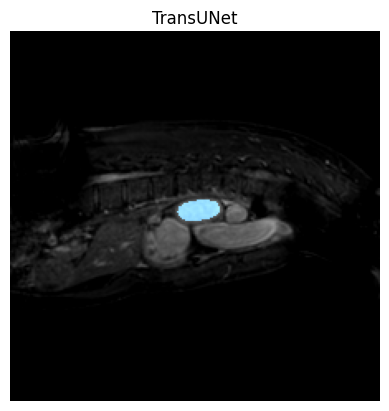

In [36]:
# Plot TransUNet Prediction
model = TransUnet.TransUnet(args.num_classes, args.n_skip)
plt.imshow(visualize_prediction(args, sample_image, model))
plt.title("TransUNet")
plt.axis("off")
plt.show()

In [17]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of TransUnet parameters: {total_params}")

Total number of TransUnet parameters: 105251362


In [ ]:
# Plot MambaUnet Prediction
model = MambaUnet.MambaUnet(args.num_classes)
plt.imshow(visualize_prediction(args, sample_image, model))
plt.axis("off")
plt.show()

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of MambaUNet parameters: {total_params}")